# Simulated/"hybrid" Motion

In [1]:
import matplotlib.pyplot as plt
from pisces.experiments import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
w = sets['walch_et_al']
i = w.ids[0]

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Failed to apply the default TensorFlow Lite delegate indexed at 0 because of incompatibility between runtime and delegate. Ignoring the error, and continuing anyway.


In [2]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits


loo = LeaveOneOutSplitter()

split_models, preprocessed_data, splits = run_splits(loo, sets['walch_et_al'], 500, SGDLogisticRegression)

31it [00:03,  8.03it/s]


prediction: (914,), labels: (956,)


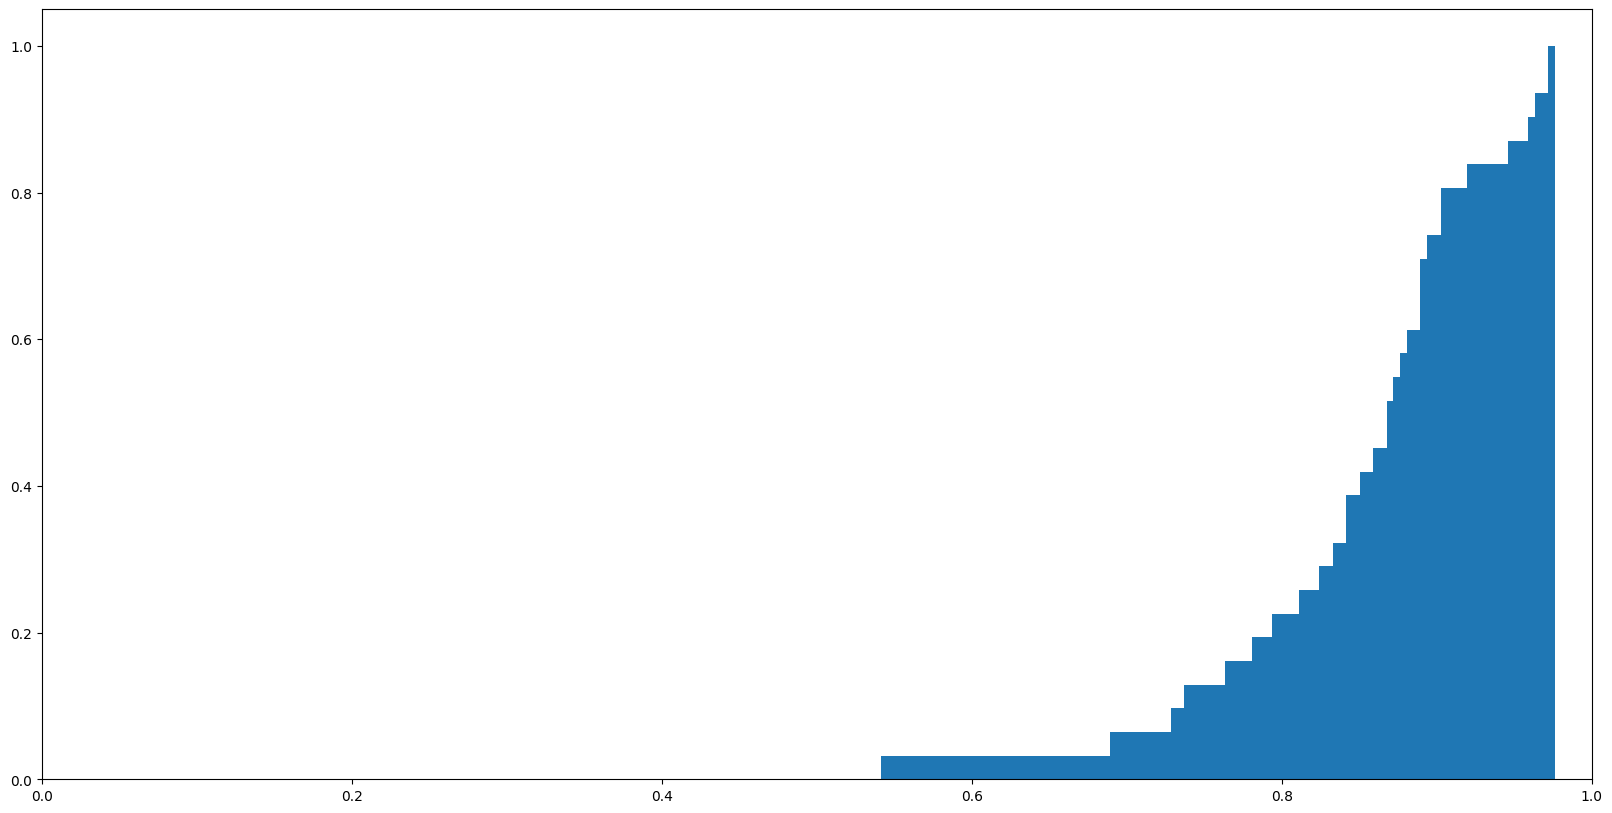

In [5]:

import matplotlib.pyplot as plt

SPLIT_NUMBER = 0

aucs = [
    split_models[i].roc_auc(
        preprocessed_data[
            splits[i][1][0]])
    for i in range(len(split_models))
]
plt.figure(figsize=(20, 10))
plt.xlim(0, 1)
_ = plt.hist(aucs,
             cumulative=True,
             density=True,
             bins=100)

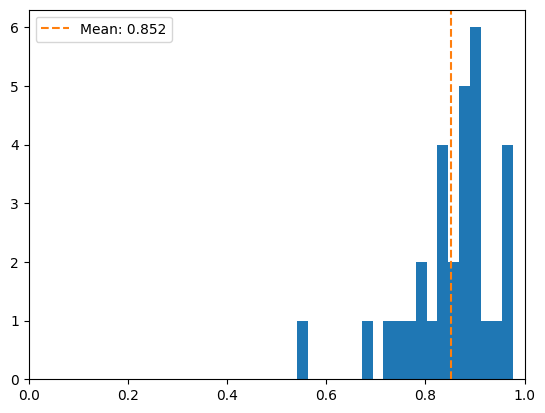

In [7]:

# plt.ylim(0, 1)
import numpy as np


plt.xlim(0, 1)
plt.hist(aucs, bins=20)

# plot the mean as a vertical 'tab:orange' line
plt.axvline(np.mean(aucs), color='tab:orange', linestyle='--', label=f"Mean: {np.mean(aucs):.3f}")
plt.legend()

In [8]:
#| export

from typing import List
from sklearn.metrics import auc_score

from pisces.utils import avg_steps

def add_rocs(ax, fprs: List[np.ndarray], tprs: List[np.ndarray], x_class: str = "SLEEP", y_class: str = "WAKE", min_auc: float = 0.0):
    
    aucs = np.array([
        auc_score(fpr, tpr)
        for fpr, tpr in zip(fprs, tprs)
    ])

    all_fprs, avg_curve = avg_steps(
            xs=[list(fprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
            ys=[list(tprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
        )

    avg_auc = np.mean(aucs[aucs > min_auc])

    ax.step(
        all_fprs,
        avg_curve,
        c="tab:blue",
        where="post",
        label=f"All splits avg ROC-AUC: {avg_auc:0.3f}",
    )
    for roc in zip(fprs, tprs):
        ax.step(roc[0], roc[1], "tab:orange", alpha=0.2, where="post")
    ax.plot([0, 1], [0, 1], "-.", c="black")

    ax.set_ylabel(f"Fraction of {y_class} scored as {y_class}")
    ax.set_xlabel(f"Fraction of {x_class} scored as {y_class}")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ImportError: cannot import name 'auc_score' from 'sklearn.metrics' (/Users/ericcanton/mambaforge/envs/pisces/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

prediction: (914,), labels: (956,)


NameError: name 'add_rocs' is not defined

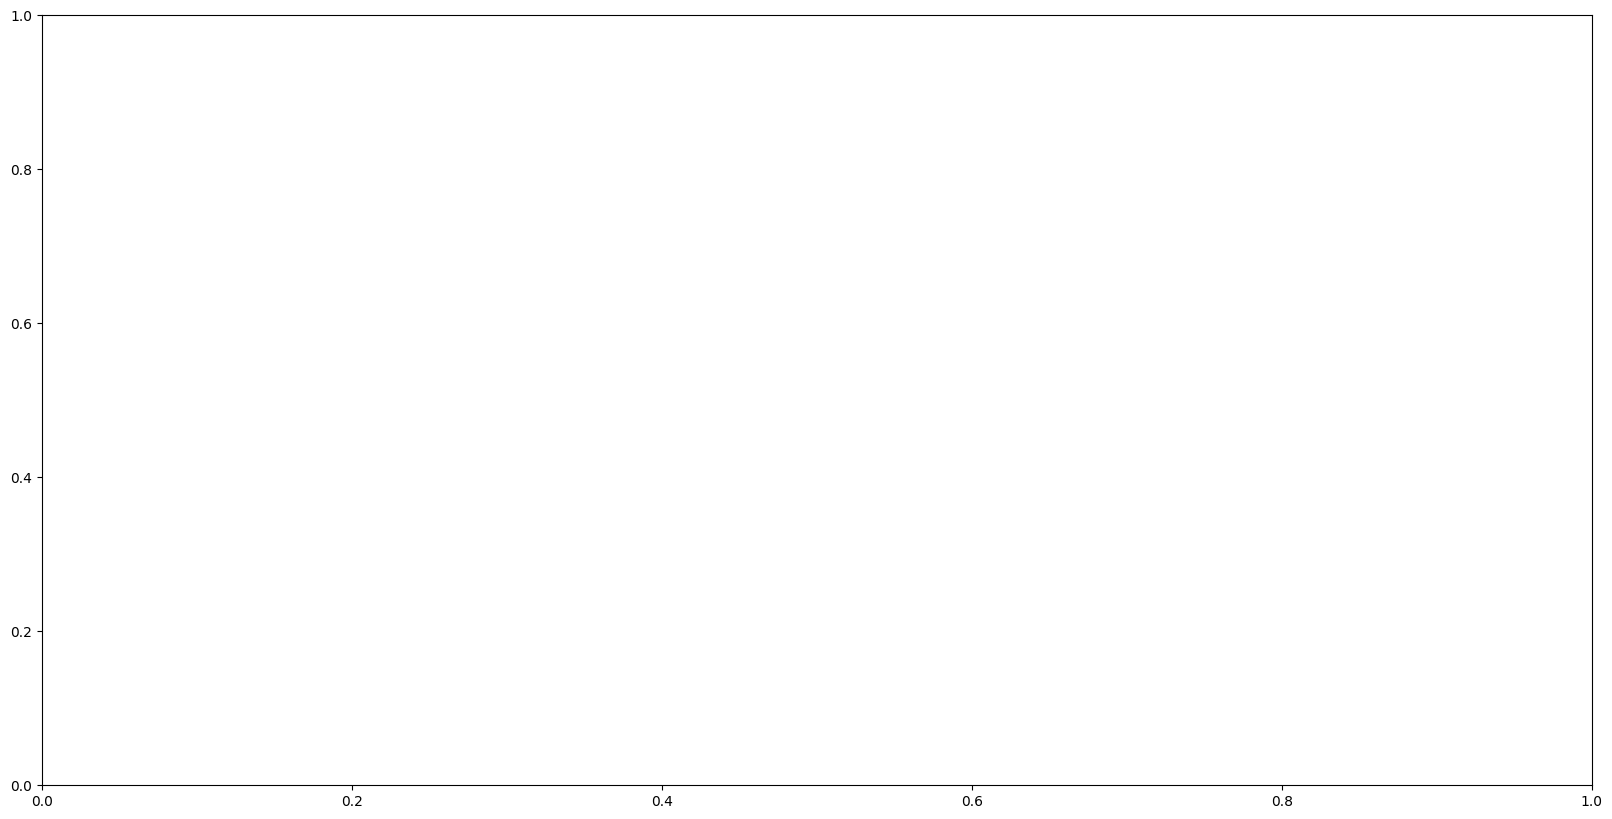

In [9]:


roc_curves = [
    split_models[i].roc_curve(
        preprocessed_data[
            splits[i][1][0]])
    for i in range(len(split_models))
]
fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    ax, 
    [fpr for fpr, _ in roc_curves], 
    [tpr for _, tpr in roc_curves],
    min_auc=0.7)
ax.legend(loc='lower right')

### MO evaluation

In [ ]:
import random


w = sets['walch_et_al']
subj = w.ids[random.randint(0, len(w.ids))]
X, y = MOResUNetPretrained.get_needed_X_y(w, subj)
print("X.shape =", X.shape)
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# ax1.imshow(.T)
spec = X[0, 1:, :, 0].T
ax1.imshow(spec, origin="lower", aspect="auto")#, vmin=vmin, vmax=vmax)
ax1.set_title('Spectrogram, Time : Freq')
ax1.set_xlabel('Time')
ax1.set_ylabel('Freq')

ax2.plot(spec)
ax2.set_title('Spectrogram, Frequency : Power ')
ax2.set_xlabel('Freq')
ax2.set_ylabel('Power')
ax3.plot(spec.T)
ax3.set_title('Spectrogram, Time : Power')
ax3.set_xlabel('Time')
ax3.set_ylabel('Power')

plt.tight_layout()
plt.show()


NameError: name 'sets' is not defined

In [ ]:
mo = MOResUNetPretrained()


In [ ]:
y_hat_proba = mo.predict_probabilities(X)

In [ ]:
y_hat_proba.shape

(1, 1024, 4)

In [ ]:
y.shape

(719,)

0.623728813559322

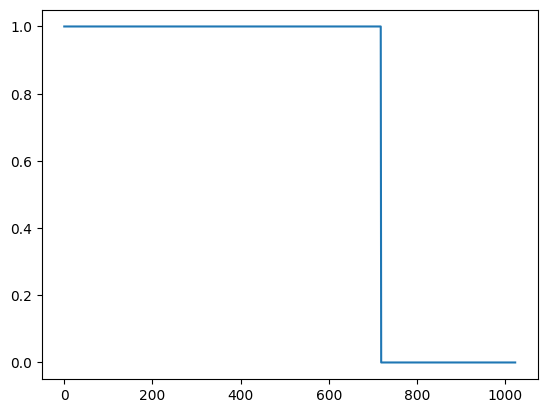

In [ ]:
from pisces.utils import pad_to_hat


y_hat = np.argmax(y_hat_proba, axis=-1).reshape(-1)
y_hat.shape
y_padded = pad_to_hat(y, y_hat)
mask = pad_to_hat(np.ones(y.shape), y_hat)
plt.plot(mask, label='MASK')
# plt.plot(y_hat, label='Predicted')
# plt.plot(y_padded, label='True')
roc_auc_score(y_padded, y_hat, sample_weight=mask)